# Packages

In [ ]:
# Visualisation
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
from pyvis.network import Network

# Data analysis / Data processing
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = "{:,.2f}".format
from datetime import time, timedelta, datetime
import numpy as np
import networkx as nx
from collections import defaultdict
import ast

# Maths & Stats
import math 
import scipy.stats as st
from scipy import stats
from scipy.stats import norm
import statsmodels.stats.weightstats as ws
from statsmodels.stats.proportion import test_proportions_2indep
import AB_library
from ambrosia.designer import Designer
from ambrosia.tester import Tester
from expab import get_mde
from expab import get_mde_ratio
from expab import ttest
from expab import ztest_proportion
from expab import ttest_delta
from expab import method_benjamini_hochberg

# System library
import os
import ipywidgets
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
tqdm.pandas()
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
%config InlineBackend.figure_format='retina'
# from itables import init_notebook_mode
# init_notebook_mode(all_interactive=True)
import openpyxl
from typing import List, Tuple, Union


# Data connection
from google.cloud import bigquery
bigquery_client = bigquery.Client(project='analytics-dev-333113')


# Useful functions
def cycle_sql(start, end, query, weeks=False):
    """
    You have to use {date} in your script to add cycle date into this backets
    """
    date_start = datetime.strptime(start, '%Y-%m-%d')
    date_end = datetime.strptime(end, '%Y-%m-%d')

    if weeks == False:
        daterange = [(date_start + timedelta(days=x)).strftime('%Y-%m-%d') for x in range(((date_end-date_start).days)+1)]
    else:
        daterange = [(date_start + timedelta(weeks=x)).strftime('%Y-%m-%d') for x in range(((date_end-date_start).days//7)+1)] # weeks dividing days by 7

    total_df = pd.DataFrame()

    counter = 0

    for date in daterange:
        counter+=1
        print(f"{counter}) Uploading - {date}:", datetime.today().strftime('%Y-%m-%d %H:%M:%S'))
        script = query.format(date = date)
        df_cycle = bigquery_client.query(script).to_dataframe()
        if df_cycle.empty == True:
            print('Dataframe is empty')
        total_df = pd.concat([df_cycle, total_df])
    return total_df

def read_bq(query, project='analytics-dev-333113'):
    client = bigquery.Client(project=project)
    query_job = client.query(query)
    result_df = query_job.to_dataframe()
    return result_df

def display_side_by_side(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display_html(
        html_str.replace('table','table style="display:inline"'), 
        raw=True
    )

## Functions

In [144]:
def ztest_proportion(
    df: pd.DataFrame,
    metric_col: str,
    ab_group_col: str,
    pairs_list: List[Tuple[int, int]] = [(0, 1)],
    corrected_ci: float = 0.95,
    flag_notation: bool = False
    ) -> pd.DataFrame:
    """Perform proportion tests between two groups."""
    res_table = pd.DataFrame()
    tail = (1 + corrected_ci) / 2
    for pair in pairs_list:
        num0 = df[df[ab_group_col] == pair[0]][metric_col].sum()
        denom0 = df[df[ab_group_col] == pair[0]][metric_col].count()
        num1 = df[df[ab_group_col] == pair[1]][metric_col].sum()
        denom1 = df[df[ab_group_col] == pair[1]][metric_col].count()
        p0 = num0 / denom0
        p1 = num1 / denom1
        std0 = df[df[ab_group_col] == pair[0]][metric_col].std()
        std1 = df[df[ab_group_col] == pair[1]][metric_col].std()
        r = test_proportions_2indep(
            num0, denom0,
            num1, denom1,
            value=0,
            method='wald',
            compare='diff',
            alternative='two-sided',
            return_results = True
        )
        se = np.sqrt(r.variance)
        delta = p1 - p0
        delta_per = (p1 / p0 - 1) * 100
        lb = delta - stats.norm.ppf(tail) * se
        ub = delta + stats.norm.ppf(tail) * se
        lb_per = lb * 100 / p0
        ub_per = ub * 100 / p0
        
        if flag_notation == True:
            print(f'\nComparison between groups: {pair[0]} and {pair[1]}')
            print(f'statistic: {r.statistic}, pvalue: {r.pvalue}')
            print(f'delta = {delta}')
            print(f'delta,% = {delta_per}%')
            print(f'Confidence interval for delta: ({lb}, {ub})')
            print(f'Confidence interval for delta, %: ({lb_per}, {ub_per})')

        result = pd.DataFrame(
            np.array([metric_col, denom0, denom1, pair[0], pair[1], r.statistic, r.pvalue, p0, p1, delta, delta_per, lb, ub, lb_per, ub_per]).reshape(1, -1),
            columns=['metric_name', 
                     'group0_sample_size', 
                     'group1_sample_size', 
                     'group0', 
                     'group1', 
                     'statistic', 
                     'pvalue', 
                     'mean0', 
                     'mean1', 
                     'diff_mean', 
                     'diff_mean_%', 
                     'lower_boundary', 
                     'upper_boundary', 
                     'lower_boundary_%', 
                     'upper_boundary_%',]
        )
        res_table = pd.concat([res_table, result])

        for column in res_table.columns[5:]:
            res_table[column] = res_table[column].astype(float)
        
    return res_table

def ttest(
    df: pd.DataFrame,
    metric_col: str,
    ab_group_col: str,
    pairs_list: List[Tuple[int, int]] = [(0, 1)],
    corrected_ci: float = 0.95,
    flag_notation: bool = False
    ) -> pd.DataFrame:
    """Perform t-tests between two groups."""
    res_table = pd.DataFrame()
    tail = (1 + corrected_ci) / 2
    for pair in pairs_list:
        sample0 = df.loc[df[ab_group_col] == pair[0], metric_col]
        sample1 = df.loc[df[ab_group_col] == pair[1], metric_col]
        m0 = sample0.mean()
        m1 = sample1.mean()
        v0 = sample0.std()**2
        v1 = sample1.std()**2
        n0 = len(sample0)
        n1 = len(sample1)
        t, pvalue, df_ = ws.ttest_ind(
            sample0,
            sample1,
            alternative='two-sided',
            usevar='unequal'
        )
        se = np.sqrt(v0 / n0 + v1 / n1)
        delta = m1 - m0
        delta_per = (m1 / m0 - 1) * 100
        lb = delta - stats.t.ppf(tail, df_) * se
        ub = delta + stats.t.ppf(tail, df_) * se
        lb_per = lb * 100 / m0
        ub_per = ub * 100 / m0
        
        if flag_notation == True:
            print(f'\nComparison between groups: {pair[0]} and {pair[1]}')
            print(f't-statistic: {t}, pvalue: {pvalue}, df: {df_}')
            print(f'delta = {delta}')
            print(f'delta,% = {delta_per}%')
            print(f'Confidence interval for delta: ({lb}, {ub})')
            print(f'Confidence interval for delta, %: ({lb_per}, {ub_per})')

        result = pd.DataFrame(
            np.array([metric_col, n0, n1, pair[0], pair[1], t, 
            # df_, 
            pvalue, m0, m1, delta, delta_per, lb, ub, lb_per, ub_per]).reshape(1, -1),
            columns=['metric_name', 
                     'group0_sample_size', 
                     'group1_sample_size',
                     'group0', 
                     'group1', 
                     'statistic', 
                    #  'df', 
                     'pvalue', 
                     'mean0', 
                     'mean1', 
                     'diff_mean', 
                     'diff_mean_%', 
                     'lower_boundary', 
                     'upper_boundary', 
                     'lower_boundary_%', 
                     'upper_boundary_%']
        )
        res_table = pd.concat([res_table, result])
    
    for column in res_table.columns[5:]:
        res_table[column] = res_table[column].astype(float)

    return res_table

def method_benjamini_hochberg(
    pvalues: np.ndarray,
    alpha: float = 0.05
    ) -> np.ndarray:
    """Apply the Benjamini-Hochberg procedure for multiple hypothesis testing."""
    m = len(pvalues)
    array_alpha = np.arange(1, m + 1) * alpha / m
    sorted_pvalue_indexes = np.argsort(pvalues)
    res = np.zeros(m)
    for idx, pvalue_index in enumerate(sorted_pvalue_indexes):
        pvalue = pvalues[pvalue_index]
        alpha_ = array_alpha[idx]
        if pvalue <= alpha_:
            res[pvalue_index] = 1
        else:
            break
    return res.astype(int)

# Shapiro-Wilk test & Distributions
def check_normality(df, group_column, value_column):
    groups = df[group_column].unique()

    for group in groups:
        group_data = df[df[group_column] == group][value_column].dropna() 
        stat, p = stats.shapiro(group_data)
        print(f'Group {group}: W={stat:.4f}, p-value={p:.4f}')
        if p > 0.05:
            print(f'Group {group}, Metric: {value_column}: Data is normal distributed')
        else:
            print(f'Group {group}, Metric: {value_column}: Data is not normal distributed')

def plot_distribution(df, group_column, value_column):

    groups = df[group_column].unique()
    fig, axes = plt.subplots(2, 2, figsize=(14, 10), gridspec_kw={'height_ratios': [1, 1.5]})

    sns.histplot(data=df, x=value_column, hue=group_column, kde=True, bins=30, alpha=0.4, ax=axes[0, 0])
    axes[0, 0].set_title("Graph + KDE")
    axes[0, 0].set_xlabel(value_column)
    axes[0, 0].set_ylabel("Frequence")

    sns.boxplot(data=df, x=group_column, y=value_column, ax=axes[0, 1])
    axes[0, 1].set_title("Boxplot grouped")
    axes[0, 1].set_xlabel(group_column)
    axes[0, 1].set_ylabel(value_column)

    sns.histplot(df[df[group_column] == groups[0]][value_column], bins=30, kde=True, color='blue', alpha=0.5, ax=axes[1, 0])
    axes[1, 0].set_title(f'Hist for the {groups[0]}')
    axes[1, 0].set_xlabel(value_column)
    axes[1, 0].set_ylabel("frequence")

    sns.histplot(df[df[group_column] == groups[1]][value_column], bins=30, kde=True, color='orange', alpha=0.5, ax=axes[1, 1])
    axes[1, 1].set_title(f'Hist for the {groups[1]}')
    axes[1, 1].set_xlabel(value_column)
    axes[1, 1].set_ylabel("Frequence")

    plt.tight_layout()
    plt.show()

# Levene's & Bartlet's test
def levene(df, indicator, metric='mean'):
    w_stats, p_value = st.levene(
        df[df['group_name'] == 0][indicator].fillna(0), 
        df[df['group_name'] == 1][indicator].fillna(0),
                            center=metric)
    
    alpha = 0.05
    
    if p_value > alpha:
        print(f"Variance are from the same population on {metric}, {p_value}")
    else:
        print(f"Variance are from the different population on {metric}, {p_value}")
    
# Cohen's D
def cohens_d(df, metric):
    group1 = df[df['group_name']==1][metric]
    group2 = df[df['group_name']==0][metric]
    mean1, mean2 = np.mean(group1), np.mean(group2)
     
    std1, std2 = np.std(group1, ddof=1), np.std(group2, ddof=1)
    n1, n2 = len(group1), len(group2)
    pooled_std = np.sqrt(((n1 - 1) * std1 ** 2 + (n2 - 1) * std2 ** 2) / (n1 + n2 - 2))
     
    d = (mean1 - mean2) / pooled_std
     
    if d <= 0.3:
        text = print(f'Small effect: d ≈ 0-0.3 ({d:.3f})')
    elif 0.31 <= d <= 0.8:
        text = print(f'Medium effect: d ≈ 0.3-0.8 ({d:.3f})')
    elif 0.81 <= d <= 1:
        text = print(f'Large effect: d ≈ 0.8-1 ({d:.3f})')

    return text

# SRM
def srm(df):
    srm_df = pd.DataFrame()

    for city in df['city_id'].unique():
        
        observed = [
            (df.query(f'group_name == 0 and city_id == {city}')['user_id'].count()), 
            (df.query(f'group_name == 1 and city_id == {city}')['user_id'].count())
            ]

        total_traffic = sum(observed)

        expected = [total_traffic/2, total_traffic/2]

        chi = st.chisquare(observed, f_exp = expected)

        if chi[1] < 0.01:
            conclusion = "Sample ratio mismatch (SRM) is observed"
        else:
            conclusion = "Sample ratio mismatch (SRM) isnt observed"
            # print(f"{city}, {chi[1]}")

        
        new_srm_df = pd.DataFrame(
            [[city, observed, total_traffic, expected, round(chi[1], 3), conclusion]], 
            columns=['city_name',  'sample_sizes', 'total_size', 'expected_sizes', 'chi_value', 'conclusion']
            )

        srm_df = pd.concat([srm_df, new_srm_df]).sort_values(['city_name', 'total_size'], ascending=False).reset_index(drop=True)

    return srm_df

# Calcualting the significance by cities
def calcualate_result(df_cr, df_abs):
    df_results = pd.DataFrame()

    for city in df_cr['city_name'].unique():

        absolute_values_keys_result = df_abs[df_abs['city_name']==f'{city}'].copy()

        cr_df = ztest_proportion(df_cr[df_cr['city_name']==f'{city}'], 'has_ride', 'group_name')
        cr_df['metric'] = 'Conversion'
        cr_df['cohen_d'] = cohens_d(df_cr[df_cr['city_name']==f'{city}'], 'has_ride')

        rides_df = ttest(absolute_values_keys_result, 'rides', 'group_name')
        rides_df['metric'] = 'Quantitive'
        rides_df['cohen_d'] = cohens_d(absolute_values_keys_result, 'rides')

        gmv_df = ttest(absolute_values_keys_result, 'gmv', 'group_name')
        gmv_df['metric'] = 'Quantitive'
        gmv_df['cohen_d'] = cohens_d(absolute_values_keys_result, 'gmv')

        orders_df = ttest(absolute_values_keys_result, 'orders', 'group_name')
        orders_df['metric'] = 'Quantitive'
        orders_df['cohen_d'] = cohens_d(absolute_values_keys_result, 'orders')

        df_total = pd.concat([cr_df, rides_df, gmv_df, orders_df])

        df_total['region'] = city
        df_total['segment'] = 'By city'
        df_total['significance'] = (df_total['pvalue']<0.05)*1
        df_total['corrected_pvalue'] = method_benjamini_hochberg(df_total['pvalue'].values)

        df_results = pd.concat([df_results, df_total])

    total_cr_df = ztest_proportion(df_cr, 'has_ride', 'group_name')
    total_cr_df['metric'] = 'Conversion'
    total_cr_df['cohen_d'] = cohens_d(df_cr, 'has_ride')

    total_rides_df = ttest(df_abs, 'rides', 'group_name')
    total_rides_df['metric'] = 'Quantitive'
    total_rides_df['cohen_d'] = cohens_d(df_abs, 'rides')

    total_gmv_df = ttest(df_abs, 'gmv', 'group_name')
    total_gmv_df['metric'] = 'Quantitive'
    total_gmv_df['cohen_d'] = cohens_d(df_abs, 'gmv')

    total_orders_df = ttest(df_abs, 'orders', 'group_name')
    total_orders_df['metric'] = 'Quantitive'
    total_orders_df['cohen_d'] = cohens_d(df_abs, 'orders')


    total_total_df = pd.concat([total_cr_df, total_rides_df, total_gmv_df, total_orders_df])
    total_total_df['region'] = 'All'
    total_total_df['segment'] = 'Total'
    total_total_df['significance'] = (df_total['pvalue']<0.05)*1
    total_total_df['corrected_pvalue'] = method_benjamini_hochberg(df_total['pvalue'].values)

    df_results = pd.concat([df_results, total_total_df])

    df_results

    return df_results

# Design of experiment

### Pulling the data

In [3]:
# df_cancel_rate_after_check = read_bq("""

# """)

df_cr_to_ride = read_bq("""
    WITH liveness AS (SELECT user_id,
                         os_name,
                         event_dt_part,
                         city_id,
                         country_id,
                         city_name,
                         country_name,
                         fulfilled_flow,
                         MIN(IF(name = 'client.verification_start.show', client_time,
                                NULL)) AS banner_show,
                         MIN(IF(name = 'client.verification_start.click', client_time,
                                NULL)) AS banner_click,
                         MIN(IF(name = 'client.verification_flow_result_status.show' AND
                                LOWER(status) = 'approve',
                                client_time,
                                NULL)) AS status_result
                  FROM (SELECT user_id,
                               name,
                               os_name,
                               event_dt_part,
                               TIMESTAMP_MILLIS(client_time)                                           AS client_time,
                               t1.city_id,
                               t2.city_name,
                               t2.country_id,
                               t2.country_name,
                               JSON_EXTRACT_SCALAR(payload, '$.status')                                AS status,
                               IF(LAG(JSON_EXTRACT_SCALAR(payload, '$.verification_flow'))
                                      OVER (PARTITION BY user_id, event_dt_part ORDER BY client_time) IS NULL,
                                  JSON_EXTRACT_SCALAR(payload, '$.verification_flow'),
                                  LAG(JSON_EXTRACT_SCALAR(payload, '$.verification_flow'))
                                      OVER (PARTITION BY user_id, event_dt_part ORDER BY client_time)) AS fulfilled_flow,
                        FROM indriver-e6e40.ods_event_tracker.event t1
                                 JOIN indriver-e6e40.heap.vw_macroregion_mapping t2
                                      ON
                                          t1.city_id = t2.city_id
                        WHERE 1 = 1
                          AND t1.city_id IN
                              (4263, 4267, 4243, 4545, 4540, 4197, 4530, 5568, 4255, 4559, 4300, 4227, 4261, 5573, 4266,
                               4196, 4376, 4154, 798,
                               4225, 4198, 4385, 4271, 4374, 4299, 5368, 4229, 4199, 4524, 4242, 4143, 4155, 4517, 5589,
                               5548, 4755, 4397, 4226,
                               4269, 4404, 5600, 4373, 4375, 4153, 4231, 5535, 4200, 5528, 4234, 4825, 4142, 5536, 4264,
                               4549, 4228, 5291, 4257,
                               4516)
                          AND name IN (
                                       'client.verification_start.show',
                                       'client.verification_start.click',
                                       'client.verification_flow_result_status.show'
                            )
                          AND event_dt_part >= '2025-01-01'
                        QUALIFY ROW_NUMBER() OVER (PARTITION BY user_id, name, event_dt_part ORDER BY client_time) = 1)
                  GROUP BY 1, 2, 3, 4, 5, 6, 7, 8),
     rides AS (SELECT order_uuid,
                      user_id    AS pass_id,
                      driver_id,
                      city_id    AS order_city_id,
                      country_id AS order_country_id,
                      status_order,
                      order_timestamp,
                      at_pickup_dttm,
                      departed_pickup_dttm,
                      at_destination_dttm,
                      departed_destination_dttm,
                      driveraccept_timestamp,
                      driverarrived_timestamp,
                      driverstarttheride_timestamp,
                      driverdone_timestamp,
                      clientdone_timestamp,
                      clientcancel_timestamp,
                      drivercancel_timestamp,
                      user_reg_date,
                      driver_reg_date,
                      stage,
                      created_date_order_part,
                      duration_in_seconds
               FROM indriver-e6e40.imart.incity_detail_new_order
               WHERE created_date_order_part >= '2025-01-01'
                 AND status_order = 'RIDE_STATUS_DONE'
                 AND driverstarttheride_timestamp IS NOT NULL
                 AND (clientcancel_timestamp IS NULL
                   AND drivercancel_timestamp IS NULL))
    SELECT *
    FROM liveness t1
            LEFT JOIN rides t2
                    ON t1.user_id = t2.pass_id
                        AND order_timestamp BETWEEN status_result AND status_result + INTERVAL 1 DAY
    QUALIFY row_number() OVER (PARTITION BY user_id ORDER BY order_timestamp) = 1
""")

print('1')
df_rides_gmv_orders = read_bq("""
    SELECT user_id,
        t1.country_id,
        t2.country_name,
        t1.city_id,
        t2.city_name,
        SUM(orders_count)                  AS orders_count,
        SUM(rides_count)                   AS rides_count,
        SUM(gmv_clean_usd)                 AS gmv,
        SUM(orders_count) / COUNT(user_id) AS orders,
        SUM(rides_count) / COUNT(user_id)  AS rides
    FROM indriver-bi.incity.tbl_incity_growth_metrics_detail t1
            JOIN indriver-e6e40.heap.vw_macroregion_mapping t2
                ON
                    t1.city_id = t2.city_id
    WHERE user_type = 'pass'
    AND t1.city_id IN
        (4263, 4267, 4243, 4545, 4540, 4197, 4530, 5568, 4255, 4559, 4300, 4227, 4261, 5573, 4266, 4196, 4376, 4154, 798,
        4225, 4198, 4385, 4271, 4374, 4299, 5368, 4229, 4199, 4524, 4242, 4143, 4155, 4517, 5589, 5548, 4755, 4397, 4226,
        4269, 4404, 5600, 4373, 4375, 4153, 4231, 5535, 4200, 5528, 4234, 4825, 4142, 5536, 4264, 4549, 4228, 5291, 4257,
        4516)
    AND metric_date_utc >= '2025-01-01'
    GROUP BY 1, 2, 3, 4, 5
""")

print('2')
df_sample_size = read_bq("""
        WITH cte AS (SELECT user_id,
                        os_name,
                        event_dt_part,
                        city_id,
                        country_id,
                        city_name,
                        country_name,
                        fulfilled_flow,
                        MIN(IF(name = 'client.verification_start.show', client_time,
                            NULL)) AS banner_show,
                        MIN(IF(name = 'client.verification_start.click', client_time,
                            NULL)) AS banner_click,
                        MIN(IF(name = 'client.verification_flow_result_status.show' AND
                            LOWER(status) = 'approve',
                            client_time,
                            NULL)) AS status_result
                FROM (SELECT user_id,
                            name,
                            os_name,
                            event_dt_part,
                            TIMESTAMP_MILLIS(client_time)                                           AS client_time,
                            t1.city_id,
                            t2.city_name,
                            t2.country_id,
                            t2.country_name,
                            JSON_EXTRACT_SCALAR(payload, '$.status')                                AS status,
                            IF(LAG(JSON_EXTRACT_SCALAR(payload, '$.verification_flow'))
                                    OVER (PARTITION BY user_id, event_dt_part ORDER BY client_time) IS NULL,
                                JSON_EXTRACT_SCALAR(payload, '$.verification_flow'),
                                LAG(JSON_EXTRACT_SCALAR(payload, '$.verification_flow'))
                                    OVER (PARTITION BY user_id, event_dt_part ORDER BY client_time)) AS fulfilled_flow,
                    FROM indriver-e6e40.ods_event_tracker.event t1
                                JOIN indriver-e6e40.heap.vw_macroregion_mapping t2
                                    ON
                                        t1.city_id = t2.city_id
                    WHERE 1 = 1
                        AND t1.city_id IN
                            (4263, 4267, 4243, 4545, 4540, 4197, 4530, 5568, 4255, 4559, 4300, 4227, 4261, 5573, 4266,
                            4196, 4376, 4154, 798,
                            4225, 4198, 4385, 4271, 4374, 4299, 5368, 4229, 4199, 4524, 4242, 4143, 4155, 4517, 5589,
                            5548, 4755, 4397, 4226,
                            4269, 4404, 5600, 4373, 4375, 4153, 4231, 5535, 4200, 5528, 4234, 4825, 4142, 5536, 4264,
                            4549, 4228, 5291, 4257,
                            4516)
                        AND name IN (
                                    'client.verification_start.show',
                                    'client.verification_start.click',
                                    'client.verification_flow_result_status.show'
                        )
                        AND event_dt_part >= '2025-01-01'
                    QUALIFY ROW_NUMBER() OVER (PARTITION BY user_id, name, event_dt_part ORDER BY client_time) = 1)
                GROUP BY 1, 2, 3, 4, 5, 6, 7, 8)
    SELECT event_dt_part,
        DATE_TRUNC(event_dt_part, WEEK)  AS weekly,
        DATE_TRUNC(event_dt_part, MONTH) AS monthly,
        city_id,
        city_name,
        COUNT(user_id)                   AS users
    FROM cte
    WHERE status_result IS NOT NULL
    GROUP BY 1, 2, 3, 4, 5
""")

print('3')
df_cancel_rate_accepted = read_bq("""
        WITH liveness AS (SELECT user_id,
                                        os_name,
                                        event_dt_part,
                                        city_id,
                                        country_id,
                                city_name,
                                country_name,
                                fulfilled_flow,
                                MIN(IF(name = 'client.verification_start.show', client_time,
                                        NULL)) AS banner_show,
                                MIN(IF(name = 'client.verification_start.click', client_time,
                                        NULL)) AS banner_click,
                                MIN(IF(name = 'client.verification_flow_result_status.show' AND
                                        LOWER(status) = 'approve',
                                        client_time,
                                        NULL)) AS status_result
                        FROM (SELECT user_id,
                                name,
                                os_name,
                                event_dt_part,
                                TIMESTAMP_MILLIS(client_time)                                           AS client_time,
                                t1.city_id,
                                t2.city_name,
                                t2.country_id,
                                t2.country_name,
                                JSON_EXTRACT_SCALAR(payload, '$.status')                                AS status,
                                IF(LAG(JSON_EXTRACT_SCALAR(payload, '$.verification_flow'))
                                        OVER (PARTITION BY user_id, event_dt_part ORDER BY client_time) IS NULL,
                                        JSON_EXTRACT_SCALAR(payload, '$.verification_flow'),
                                        LAG(JSON_EXTRACT_SCALAR(payload, '$.verification_flow'))
                                        OVER (PARTITION BY user_id, event_dt_part ORDER BY client_time)) AS fulfilled_flow,
                                FROM indriver-e6e40.ods_event_tracker.event t1
                                        JOIN indriver-e6e40.heap.vw_macroregion_mapping t2
                                        ON
                                                t1.city_id = t2.city_id
                                WHERE 1 = 1
                                AND t1.city_id IN
                                (4263, 4267, 4243, 4545, 4540, 4197, 4530, 5568, 4255, 4559, 4300, 4227, 4261, 5573, 4266,
                                4196, 4376, 4154, 798,
                                4225, 4198, 4385, 4271, 4374, 4299, 5368, 4229, 4199, 4524, 4242, 4143, 4155, 4517, 5589,
                                5548, 4755, 4397, 4226,
                                4269, 4404, 5600, 4373, 4375, 4153, 4231, 5535, 4200, 5528, 4234, 4825, 4142, 5536, 4264,
                                4549, 4228, 5291, 4257,
                                4516)
                                AND name IN (
                                        'client.verification_start.show',
                                        'client.verification_start.click',
                                        'client.verification_flow_result_status.show'
                                )
                                AND event_dt_part >= '2025-01-01'     
                                QUALIFY ROW_NUMBER() OVER (PARTITION BY user_id, name, event_dt_part ORDER BY client_time) = 1)
                        GROUP BY 1, 2, 3, 4, 5, 6, 7, 8),
        rides AS (SELECT order_uuid,
                        user_id    AS pass_id,
                        driver_id,
                        city_id    AS order_city_id,
                        country_id AS order_country_id,
                        status_order,
                        order_timestamp,
                        at_pickup_dttm,
                        departed_pickup_dttm,
                        at_destination_dttm,
                        departed_destination_dttm,
                        driveraccept_timestamp,
                        driverarrived_timestamp,
                        driverstarttheride_timestamp,
                        driverdone_timestamp,
                        clientdone_timestamp,
                        clientcancel_timestamp,
                        drivercancel_timestamp,
                        user_reg_date,
                        driver_reg_date,
                        stage,
                        created_date_order_part,
                        duration_in_seconds
                FROM indriver-e6e40.imart.incity_detail_new_order
                WHERE created_date_order_part >= '2025-01-01'
                        AND driveraccept_timestamp IS NOT NULL
                        AND (status_order IN ('RIDE_STATUS_CANCELED_BY_CUSTOMER')
                        OR clientcancel_timestamp IS NOT NULL))
        SELECT *
        FROM liveness t1
                LEFT JOIN rides t2
                        ON t1.user_id = t2.pass_id
                        AND order_timestamp BETWEEN status_result AND status_result + INTERVAL 5 hour
        QUALIFY row_number() OVER (PARTITION BY user_id ORDER BY order_timestamp) = 1
""")

print('4')
df_cancel_rate_total = read_bq("""
        WITH liveness AS (SELECT user_id,
                                        os_name,
                                        event_dt_part,
                                        city_id,
                                        country_id,
                                city_name,
                                country_name,
                                fulfilled_flow,
                                MIN(IF(name = 'client.verification_start.show', client_time,
                                        NULL)) AS banner_show,
                                MIN(IF(name = 'client.verification_start.click', client_time,
                                        NULL)) AS banner_click,
                                MIN(IF(name = 'client.verification_flow_result_status.show' AND
                                        LOWER(status) = 'approve',
                                        client_time,
                                        NULL)) AS status_result
                        FROM (SELECT user_id,
                                name,
                                os_name,
                                event_dt_part,
                                TIMESTAMP_MILLIS(client_time)                                           AS client_time,
                                t1.city_id,
                                t2.city_name,
                                t2.country_id,
                                t2.country_name,
                                JSON_EXTRACT_SCALAR(payload, '$.status')                                AS status,
                                IF(LAG(JSON_EXTRACT_SCALAR(payload, '$.verification_flow'))
                                        OVER (PARTITION BY user_id, event_dt_part ORDER BY client_time) IS NULL,
                                        JSON_EXTRACT_SCALAR(payload, '$.verification_flow'),
                                        LAG(JSON_EXTRACT_SCALAR(payload, '$.verification_flow'))
                                        OVER (PARTITION BY user_id, event_dt_part ORDER BY client_time)) AS fulfilled_flow,
                                FROM indriver-e6e40.ods_event_tracker.event t1
                                        JOIN indriver-e6e40.heap.vw_macroregion_mapping t2
                                        ON
                                                t1.city_id = t2.city_id
                                WHERE 1 = 1
                                AND t1.city_id IN
                                (4263, 4267, 4243, 4545, 4540, 4197, 4530, 5568, 4255, 4559, 4300, 4227, 4261, 5573, 4266,
                                4196, 4376, 4154, 798,
                                4225, 4198, 4385, 4271, 4374, 4299, 5368, 4229, 4199, 4524, 4242, 4143, 4155, 4517, 5589,
                                5548, 4755, 4397, 4226,
                                4269, 4404, 5600, 4373, 4375, 4153, 4231, 5535, 4200, 5528, 4234, 4825, 4142, 5536, 4264,
                                4549, 4228, 5291, 4257,
                                4516)
                                AND name IN (
                                        'client.verification_start.show',
                                        'client.verification_start.click',
                                        'client.verification_flow_result_status.show'
                                )
                                AND event_dt_part >= '2025-01-01'     
                                QUALIFY ROW_NUMBER() OVER (PARTITION BY user_id, name, event_dt_part ORDER BY client_time) = 1)
                        GROUP BY 1, 2, 3, 4, 5, 6, 7, 8),
        rides AS (SELECT order_uuid,
                        user_id    AS pass_id,
                        driver_id,
                        city_id    AS order_city_id,
                        country_id AS order_country_id,
                        status_order,
                        order_timestamp,
                        at_pickup_dttm,
                        departed_pickup_dttm,
                        at_destination_dttm,
                        departed_destination_dttm,
                        driveraccept_timestamp,
                        driverarrived_timestamp,
                        driverstarttheride_timestamp,
                        driverdone_timestamp,
                        clientdone_timestamp,
                        clientcancel_timestamp,
                        drivercancel_timestamp,
                        user_reg_date,
                        driver_reg_date,
                        stage,
                        created_date_order_part,
                        duration_in_seconds
                FROM indriver-e6e40.imart.incity_detail_new_order
                WHERE created_date_order_part >= '2025-01-01'
                        AND (status_order IN ('RIDE_STATUS_CANCELED_BY_CUSTOMER')
                        OR clientcancel_timestamp IS NOT NULL))
        SELECT *
        FROM liveness t1
                LEFT JOIN rides t2
                        ON t1.user_id = t2.pass_id
                        AND order_timestamp BETWEEN status_result AND status_result + INTERVAL 5 hour
        QUALIFY row_number() OVER (PARTITION BY user_id ORDER BY order_timestamp) = 1
""")

Next
Next
Next


### MDE & Period calculating

In [4]:
daily = int(df_sample_size.groupby(['event_dt_part'], as_index=False)['users'].sum()['users'].mean())
weekly = int(df_sample_size.groupby(['weekly'], as_index=False)['users'].sum()['users'].mean())
monthly = int(df_sample_size.groupby(['monthly'], as_index=False)['users'].sum()['users'].mean())

df_cr_to_ride_agg = df_cr_to_ride.groupby(['user_id', 'city_name', 'fulfilled_flow'], as_index=False)[['status_result', 'order_uuid']].count()
df_cancel_rate_agg = df_cancel_rate.groupby(['user_id', 'city_name'], as_index=False)[['status_result', 'order_uuid']].count()
df_cancel_rate_total_agg = df_cancel_rate_total.groupby(['user_id', 'city_name'], as_index=False)[['status_result', 'order_uuid']].count()

effects = [1.01, 1.015, 1.05, 1.1]  # MDE in percents
sizes = [daily, weekly, weekly*2, monthly]  # Size of each group
first_type_errors = [0.01, 0.05]
second_type_errors = [0.1, 0.2]

design_cr_to_ride = Designer(
        dataframe=df_cr_to_ride_agg, 
        metrics='order_uuid'
        )

design_cr_to_ride.set_first_errors(first_type_errors)
design_cr_to_ride.set_second_errors(second_type_errors)

df_cr_to_ride_design = design_cr_to_ride.run(
            to_design='effect', 
            method='theory', 
            effects=effects,
            sizes=sizes
            )
df_cr_to_ride_design['metric'] = 'cr_to_ride'



design_gmv = Designer(
        dataframe=df_rides_gmv_orders, 
        metrics='gmv'
        )

design_gmv.set_first_errors(first_type_errors)
design_gmv.set_second_errors(second_type_errors)

df_gmv_design = design_gmv.run(
            to_design='effect', 
            method='theory', 
            effects=effects,
            sizes=sizes
            )
df_gmv_design['metric'] = 'gmv'

design_cancel_rate_accepted = Designer(
        dataframe=df_cancel_rate_agg, 
        metrics='order_uuid'
        )

design_cancel_rate_accepted.set_first_errors(first_type_errors)
design_cancel_rate_accepted.set_second_errors(second_type_errors)

df_cancel_rate_accepted_design = design_cancel_rate_accepted.run(
            to_design='effect', 
            method='theory', 
            effects=effects,
            sizes=sizes
            )
df_cancel_rate_accepted_design['metric'] = 'cancel_rate_accepted'

design_cancel_rate_total = Designer(
        dataframe=df_cancel_rate_total_agg, 
        metrics='order_uuid'
        )

design_cancel_rate_total.set_first_errors(first_type_errors)
design_cancel_rate_total.set_second_errors(second_type_errors)

df_cancel_rate_total_design = design_cancel_rate_total.run(
            to_design='effect', 
            method='theory', 
            effects=effects,
            sizes=sizes
            )
df_cancel_rate_total_design['metric'] = 'cancel_rate_total'

pd.concat([df_cr_to_ride_design, df_cancel_rate_accepted_design, df_cancel_rate_total_design, df_gmv_design])


# Calculating the results. Summarizing

### Data pulling

In [195]:
cr_to_ride = read_bq("""
WITH users AS (SELECT DISTINCT t1.user_id,
                               t1.city_id,
                               r.city_name,
                               r.country_id,
                               r.country_name,
                               created_dt_part,
                               client_time,
                               CASE
                                   WHEN group_id = 4534130 THEN 0
                                   WHEN group_id = 4534131 THEN 1
                                   ELSE NULL
                                   END group_name
               FROM indriver-e6e40.ss_ab_platform_mart.markup_users t1
                        JOIN indriver-e6e40.heap.vw_macroregion_mapping r
                             ON
                                 t1.city_id = r.city_id
                        JOIN (SELECT user_id, city_id, TIMESTAMP_MILLIS(client_time) AS client_time
                              FROM indriver-e6e40.ods_event_tracker.event
                              WHERE event_dt_part BETWEEN '2025-02-24' AND '2025-03-12'
                                AND name IN (
                                  'client.verification_flow_get_status.done'
                                  )
                                AND LOWER(JSON_EXTRACT_SCALAR(payload, '$.status')) = 'approve'
                                AND user_id IS NOT NULL
                              QUALIFY ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY event_dt_part) = 1) t2
                             ON t1.user_id = t2.user_id AND t1.city_id = t2.city_id
               WHERE test_id = 2591),
     rides AS (SELECT order_uuid,
                      user_id    AS pass_id,
                      driver_id,
                      city_id    AS order_city_id,
                      country_id AS order_country_id,
                      status_order,
                      order_timestamp,
                      at_pickup_dttm,
                      departed_pickup_dttm,
                      at_destination_dttm,
                      departed_destination_dttm,
                      driveraccept_timestamp,
                      driverarrived_timestamp,
                      driverstarttheride_timestamp,
                      driverdone_timestamp,
                      clientdone_timestamp,
                      clientcancel_timestamp,
                      drivercancel_timestamp,
                      user_reg_date,
                      driver_reg_date,
                      stage,
                      created_date_order_part,
                      duration_in_seconds
               FROM indriver-e6e40.imart.incity_detail_new_order
               WHERE created_date_order_part >= '2025-02-23'
                 AND status_order = 'RIDE_STATUS_DONE'
                 AND driverstarttheride_timestamp IS NOT NULL
                 AND (clientcancel_timestamp IS NULL
                   AND drivercancel_timestamp IS NULL))
SELECT t1.*,
       t2.order_timestamp,
       IF(t2.order_timestamp IS NOT NULL, 1, 0) AS has_ride
FROM users t1
         LEFT JOIN rides t2
                   ON t1.user_id = t2.pass_id
                       AND order_timestamp BETWEEN client_time AND client_time + INTERVAL 6 HOUR
QUALIFY row_number() OVER (PARTITION BY user_id ORDER BY order_timestamp) = 1
""")

cr_to_ride.head()

,user_id,city_id,city_name,country_id,country_name,created_dt_part,client_time,group_name,order_timestamp,has_ride
0,10800991,4255,Cali,22,Colombia,2025-03-02,2025-03-02 04:21:39.198000+00:00,1,NaT,0
1,19487824,4255,Cali,22,Colombia,2025-03-11,2025-03-11 11:01:22.810000+00:00,0,2025-03-11 11:01:27+00:00,1
2,26983497,5589,Osorno,25,Chile,2025-02-27,2025-02-27 12:18:33.192000+00:00,1,NaT,0
3,27749793,5589,Osorno,25,Chile,2025-02-26,2025-03-05 22:20:16.162000+00:00,1,NaT,0
4,27835327,4154,Fortaleza,11,Brazil,2025-02-28,2025-02-28 09:53:41.509000+00:00,0,NaT,0


In [200]:
cancel_rate = read_bq("""
WITH users AS (SELECT DISTINCT t1.user_id,
                               t1.city_id,
                               r.city_name,
                               r.country_id,
                               r.country_name,
                               created_dt_part,
                               client_time,
                               CASE
                                   WHEN group_id = 4534130 THEN 0
                                   WHEN group_id = 4534131 THEN 1
                                   ELSE NULL
                                   END group_name
               FROM indriver-e6e40.ss_ab_platform_mart.markup_users t1
                        JOIN indriver-e6e40.heap.vw_macroregion_mapping r
                             ON
                                 t1.city_id = r.city_id
                        JOIN (SELECT user_id, city_id, TIMESTAMP_MILLIS(client_time) AS client_time
                              FROM indriver-e6e40.ods_event_tracker.event
                              WHERE event_dt_part BETWEEN '2025-02-24' AND '2025-03-12'
                                AND name IN (
                                  'client.verification_flow_get_status.done'
                                  )
                                AND LOWER(JSON_EXTRACT_SCALAR(payload, '$.status')) = 'approve'
                                AND user_id IS NOT NULL
                              QUALIFY ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY event_dt_part) = 1) t2
                             ON t1.user_id = t2.user_id AND t1.city_id = t2.city_id
               WHERE test_id = 2591),
     rides AS (SELECT order_uuid,
                      user_id    AS pass_id,
                      driver_id,
                      city_id    AS order_city_id,
                      country_id AS order_country_id,
                      status_order,
                      order_timestamp,
                      at_pickup_dttm,
                      departed_pickup_dttm,
                      at_destination_dttm,
                      departed_destination_dttm,
                      driveraccept_timestamp,
                      driverarrived_timestamp,
                      driverstarttheride_timestamp,
                      driverdone_timestamp,
                      clientdone_timestamp,
                      clientcancel_timestamp,
                      drivercancel_timestamp,
                      user_reg_date,
                      driver_reg_date,
                      stage,
                      created_date_order_part,
                      duration_in_seconds
               FROM indriver-e6e40.imart.incity_detail_new_order
               WHERE created_date_order_part >= '2025-02-23')
SELECT t1.*,
       t2.order_timestamp,
       t2.status_order,
       t2.clientcancel_timestamp,
       IF((t2.status_order = 'RIDE_STATUS_CANCELED_BY_CUSTOMER' OR clientcancel_timestamp IS NOT NULL), 1,
          0) AS has_cancel
FROM users t1
         LEFT JOIN rides t2
                   ON t1.user_id = t2.pass_id
                       AND order_timestamp BETWEEN client_time AND client_time + INTERVAL 1 HOUR
QUALIFY row_number() OVER (PARTITION BY user_id ORDER BY order_timestamp) = 1
""")

cancel_rate.head()

,user_id,city_id,city_name,country_id,country_name,created_dt_part,client_time,group_name,order_timestamp,status_order,clientcancel_timestamp,has_cancel
0,10800991,4255,Cali,22,Colombia,2025-03-02,2025-03-02 04:21:39.198000+00:00,1,2025-03-02 04:21:45+00:00,ORDER_STATUS_CANCELED,2025-03-02 04:29:54+00:00,1
1,19487824,4255,Cali,22,Colombia,2025-03-11,2025-03-11 11:01:22.810000+00:00,0,2025-03-11 11:01:27+00:00,RIDE_STATUS_DONE,NaT,0
2,26983497,5589,Osorno,25,Chile,2025-02-27,2025-02-27 12:18:33.192000+00:00,1,NaT,None,NaT,0
3,27749793,5589,Osorno,25,Chile,2025-02-26,2025-03-05 22:20:16.162000+00:00,1,2025-03-05 22:20:22+00:00,ORDER_STATUS_EXPIRED,NaT,0
4,27835327,4154,Fortaleza,11,Brazil,2025-02-28,2025-02-28 09:53:41.509000+00:00,0,2025-02-28 09:54:25+00:00,ORDER_STATUS_FAILED,NaT,0


In [4]:
quant_metrics = read_bq("""
WITH metrics AS (SELECT user_id,
                        t1.country_id,
                        t2.country_name,
                        t1.city_id,
                        t2.city_name,
                        metric_date_utc,
                        SUM(orders_count)  AS orders_count,
                        SUM(rides_count)   AS rides_count,
                        SUM(gmv_clean_usd) AS gmv
                 FROM indriver-bi.incity.tbl_incity_growth_metrics_detail t1
                          JOIN indriver-e6e40.heap.vw_macroregion_mapping t2
                               ON
                                   t1.city_id = t2.city_id
                 WHERE user_type = 'pass'
                   AND metric_date_utc >= '2025-02-23'
                 GROUP BY 1, 2, 3, 4, 5, 6),
     users AS (SELECT DISTINCT t1.user_id,
                               t1.city_id,
                               created_dt_part,
                               CASE
                                   WHEN group_id = 4534130 THEN 0
                                   WHEN group_id = 4534131 THEN 1
                                   ELSE NULL
                                   END group_name
               FROM indriver-e6e40.ss_ab_platform_mart.markup_users t1
                        JOIN (SELECT user_id, city_id
                              FROM indriver-e6e40.ods_event_tracker.event
                              WHERE event_dt_part BETWEEN '2025-02-23' AND '2025-03-12'
                                AND name IN (
                                  'client.verification_flow_get_status.done'
                                  )
                                AND LOWER(JSON_EXTRACT_SCALAR(payload, '$.status')) = 'approve'
                                AND user_id IS NOT NULL
                              QUALIFY ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY event_dt_part) = 1) t2
                             ON t1.user_id = t2.user_id AND t1.city_id = t2.city_id
               WHERE test_id = 2591)
SELECT t1.user_id,
       t1.city_id,
       t1.group_name,
       SUM(t2.orders_count) AS orders_count,
       SUM(t2.rides_count)  AS rides_count,
       SUM(t2.gmv)          AS gmv
FROM users t1
         LEFT JOIN metrics t2
                   ON t1.user_id = t2.user_id
                       AND t2.metric_date_utc >= t1.created_dt_part
GROUP BY 1, 2, 3
""")

quant_metrics.head()

,user_id,city_id,group_name,orders_count,rides_count,gmv
0,198375800,4516,0,29,15,32.03
1,79116504,4264,0,24,15,42.96
2,263676162,4269,0,32,22,72.10
3,282809205,4199,0,27,17,64.93
4,282517783,4143,1,30,26,87.87


### Check the key statistics over the tests

#### Converrsion

In [184]:
srm = srm(cr_to_ride)
srm

,city_name,sample_sizes,total_size,expected_sizes,chi_value,conclusion
0,5600,"[582, 582]",1164,"[582.0, 582.0]",1.00,Sample ratio mismatch (SRM) isnt observed
1,5589,"[1483, 1482]",2965,"[1482.5, 1482.5]",0.98,Sample ratio mismatch (SRM) isnt observed
2,5573,"[1339, 1261]",2600,"[1300.0, 1300.0]",0.13,Sample ratio mismatch (SRM) isnt observed
3,5568,"[2969, 3141]",6110,"[3055.0, 3055.0]",0.03,Sample ratio mismatch (SRM) isnt observed
4,5548,"[5546, 5637]",11183,"[5591.5, 5591.5]",0.39,Sample ratio mismatch (SRM) isnt observed
5,5536,"[1562, 1488]",3050,"[1525.0, 1525.0]",0.18,Sample ratio mismatch (SRM) isnt observed
6,5535,"[679, 697]",1376,"[688.0, 688.0]",0.63,Sample ratio mismatch (SRM) isnt observed
7,5528,"[1272, 1326]",2598,"[1299.0, 1299.0]",0.29,Sample ratio mismatch (SRM) isnt observed
8,5368,"[1833, 1900]",3733,"[1866.5, 1866.5]",0.27,Sample ratio mismatch (SRM) isnt observed
9,5291,"[434, 383]",817,"[408.5, 408.5]",0.07,Sample ratio mismatch (SRM) isnt observed


In [191]:
srm.sort_values('total_size', ascending=False)['city_name'].head(10).to_list()

[4242, 4199, 4142, 4300, 4200, 4257, 4299, 4153, 4530, 4197]

In [161]:
srm_df = pd.DataFrame()
observed = [
    (cr_to_ride.query(f'group_name == 0')['user_id'].count()), 
    (cr_to_ride.query(f'group_name == 1')['user_id'].count())
    ]

total_traffic = sum(observed)

expected = [total_traffic/2, total_traffic/2]

chi = st.chisquare(observed, f_exp = expected)

if chi[1] < 0.01:
    conclusion = "Sample ratio mismatch (SRM) is observed"
else:
    conclusion = "Sample ratio mismatch (SRM) isnt observed"

new_srm_df = pd.DataFrame(
            [[observed, total_traffic, expected, round(chi[1], 3), conclusion]], 
            columns=['sample_sizes', 'total_size', 'expected_sizes', 'chi_value', 'conclusion']
            )

srm_df = pd.concat([srm_df, new_srm_df]).sort_values(['total_size'], ascending=False).reset_index(drop=True)
srm_df


,sample_sizes,total_size,expected_sizes,chi_value,conclusion
0,"[336103, 336618]",672721,"[336360.5, 336360.5]",0.53,Sample ratio mismatch (SRM) isnt observed


In [136]:
cr_to_ride_res = expab.ztest_proportion(cr_to_ride, 'has_ride', 'group_name')
cancel_rate_res = expab.ztest_proportion(cancel_rate, 'has_cancel', 'group_name')

In [138]:
res_df_cr = pd.concat([cancel_rate_res, cr_to_ride_res])

In [202]:
cancel_rate

,user_id,city_id,city_name,country_id,country_name,created_dt_part,client_time,group_name,order_timestamp,status_order,clientcancel_timestamp,has_cancel
0,10800991,4255,Cali,22,Colombia,2025-03-02,2025-03-02 04:21:39.198000+00:00,1,2025-03-02 04:21:45+00:00,ORDER_STATUS_CANCELED,2025-03-02 04:29:54+00:00,1
1,19487824,4255,Cali,22,Colombia,2025-03-11,2025-03-11 11:01:22.810000+00:00,0,2025-03-11 11:01:27+00:00,RIDE_STATUS_DONE,NaT,0
2,26983497,5589,Osorno,25,Chile,2025-02-27,2025-02-27 12:18:33.192000+00:00,1,NaT,None,NaT,0
3,27749793,5589,Osorno,25,Chile,2025-02-26,2025-03-05 22:20:16.162000+00:00,1,2025-03-05 22:20:22+00:00,ORDER_STATUS_EXPIRED,NaT,0
4,27835327,4154,Fortaleza,11,Brazil,2025-02-28,2025-02-28 09:53:41.509000+00:00,0,2025-02-28 09:54:25+00:00,ORDER_STATUS_FAILED,NaT,0
...,...,...,...,...,...,...,...,...,...,...,...,...
673551,284236286,5568,Calama,25,Chile,2025-03-05,2025-03-05 17:43:22.010000+00:00,1,2025-03-05 17:43:33+00:00,RIDE_STATUS_DONE,NaT,0
673552,284405951,5568,Calama,25,Chile,2025-03-06,2025-03-07 16:22:41.474000+00:00,1,2025-03-07 16:22:53+00:00,RIDE_STATUS_DONE,NaT,0
673553,284979258,5568,Calama,25,Chile,2025-03-10,2025-03-10 11:16:50.694000+00:00,0,2025-03-10 11:17:01+00:00,ORDER_STATUS_CANCELED,2025-03-10 11:19:00+00:00,1
673554,285056929,5568,Calama,25,Chile,2025-03-10,2025-03-10 23:03:36.790000+00:00,0,NaT,None,NaT,0


In [205]:
list_of_cities = [4242, 4199, 4142, 4300, 4200, 4257, 4299, 4153, 4530, 4197]
res_by_countries_cr = pd.DataFrame()

for country in cr_to_ride['country_name'].unique():
    city_df = expab.ztest_proportion(cr_to_ride[cr_to_ride['country_name']==country], 'has_ride', 'group_name')
    city_df['country_name'] = country
    res_by_countries_cr = pd.concat([res_by_countries_cr, city_df])

res_by_countries_cancel = pd.DataFrame()

for country in cancel_rate['country_name'].unique():
    city_df = expab.ztest_proportion(cancel_rate[cancel_rate['country_name']==country], 'has_cancel', 'group_name')
    city_df['country_name'] = country
    res_by_countries_cancel = pd.concat([res_by_countries_cancel, city_df])

res_df_countries = pd.concat([res_by_countries_cr, res_by_countries_cancel])

res_df_countries['significance'] = (res_df_countries['pvalue']<0.05)*1
res_df_countries['corrected_pvalue'] = method_benjamini_hochberg(res_df_countries['pvalue'].values)

res_df_countries


,metric_name,group0_sample_size,group1_sample_size,group0,group1,statistic,pvalue,mean0,mean1,diff_mean,diff_mean_%,lb,ub,lb_%,ub_%,country_name,significance,corrected_pvalue
0,has_ride,94496,94484,0,1,-3.25,0.00,0.55,0.55,0.01,1.36,0.00,0.01,0.54,2.18,Colombia,1,1
0,has_ride,46426,46721,0,1,-3.20,0.00,0.63,0.64,0.01,1.58,0.00,0.02,0.61,2.56,Chile,1,1
0,has_ride,50045,50245,0,1,-1.63,0.10,0.40,0.40,0.01,1.27,-0.00,0.01,-0.26,2.80,Brazil,0,0
0,has_ride,8613,8663,0,1,-1.07,0.29,0.46,0.46,0.01,1.78,-0.01,0.02,-1.48,5.03,Ecuador,0,0
0,has_ride,28227,27852,0,1,-0.46,0.65,0.46,0.46,0.00,0.42,-0.01,0.01,-1.38,2.22,Mexico,0,0
0,has_ride,2244,2186,0,1,0.06,0.95,0.73,0.73,-0.00,-0.12,-0.03,0.03,-3.74,3.50,Honduras,0,0
0,has_ride,5450,5395,0,1,0.78,0.43,0.67,0.66,-0.01,-1.06,-0.02,0.01,-3.71,1.60,Dominican Republic,0,0
0,has_ride,28149,28088,0,1,-1.20,0.23,0.46,0.46,0.01,1.11,-0.00,0.01,-0.70,2.91,South Africa,0,0
0,has_ride,3415,3375,0,1,-0.03,0.98,0.60,0.60,0.00,0.05,-0.02,0.02,-3.81,3.92,Guatemala,0,0
0,has_ride,62069,62481,0,1,-0.50,0.62,0.57,0.57,0.00,0.25,-0.00,0.01,-0.72,1.22,Peru,0,0


#### Quantitive

In [120]:
srm(quant_metrics)

,city_name,sample_sizes,total_size,expected_sizes,chi_value,conclusion
0,5600,"[610, 599]",1209,"[604.5, 604.5]",0.75,Sample ratio mismatch (SRM) isnt observed
1,5589,"[1539, 1551]",3090,"[1545.0, 1545.0]",0.83,Sample ratio mismatch (SRM) isnt observed
2,5573,"[1393, 1312]",2705,"[1352.5, 1352.5]",0.12,Sample ratio mismatch (SRM) isnt observed
3,5568,"[3152, 3323]",6475,"[3237.5, 3237.5]",0.03,Sample ratio mismatch (SRM) isnt observed
4,5548,"[5837, 5952]",11789,"[5894.5, 5894.5]",0.29,Sample ratio mismatch (SRM) isnt observed
5,5536,"[1633, 1561]",3194,"[1597.0, 1597.0]",0.20,Sample ratio mismatch (SRM) isnt observed
6,5535,"[714, 734]",1448,"[724.0, 724.0]",0.60,Sample ratio mismatch (SRM) isnt observed
7,5528,"[1357, 1414]",2771,"[1385.5, 1385.5]",0.28,Sample ratio mismatch (SRM) isnt observed
8,5368,"[1932, 1976]",3908,"[1954.0, 1954.0]",0.48,Sample ratio mismatch (SRM) isnt observed
9,5291,"[463, 409]",872,"[436.0, 436.0]",0.07,Sample ratio mismatch (SRM) isnt observed


In [67]:
border_0, border_1 = (
    np.percentile(quant_metrics[quant_metrics['group_name']==0]['gmv'].fillna(0), 99),
    np.percentile(quant_metrics[quant_metrics['group_name']==1]['gmv'].fillna(0), 99)
    )

In [116]:
border_0, border_1 = (
    np.percentile(quant_metrics[quant_metrics['group_name']==0]['gmv'].fillna(0), 99),
    np.percentile(quant_metrics[quant_metrics['group_name']==1]['gmv'].fillna(0), 99)
    )

indx = (
    list(quant_metrics[(quant_metrics['group_name']==0)&(quant_metrics['gmv'] > border_0)].index) + list(quant_metrics[(quant_metrics['group_name']==1)&(quant_metrics['gmv'] > border_1)].index)
)

quant_metrics_corr = quant_metrics.drop(index=indx)
quant_metrics_corr['gmv'] = quant_metrics_corr['gmv'].fillna(0)
quant_metrics_corr['rides_count'] = quant_metrics_corr['rides_count'].fillna(0)
quant_metrics_corr['orders_count'] = quant_metrics_corr['orders_count'].fillna(0)

quant_metrics_corr.groupby('group_name', as_index=False)[['gmv', 'rides_count', 'orders_count']].agg(['mean', 'std'])

gmv      rides_count      orders_count     
           mean  std        mean  std         mean  std
group_name                                             
0          6.11 8.50        1.52 2.28         3.63 4.77
1          6.17 8.55        1.54 2.29         3.70 4.87

In [119]:
quant_metrics.groupby('group_name', as_index=False)[['gmv', 'rides_count', 'orders_count']].mean()

,group_name,gmv,rides_count,orders_count
0,0,7.25,1.79,4.13
1,1,7.22,1.78,4.16


In [91]:
check_normality(quant_metrics_corr, 'group_name', 'gmv')

Group 0: W=0.7242, p-value=0.0000
Group 0, Metric: gmv: Data is not normal distributed
Group 1: W=0.7223, p-value=0.0000
Group 1, Metric: gmv: Data is not normal distributed


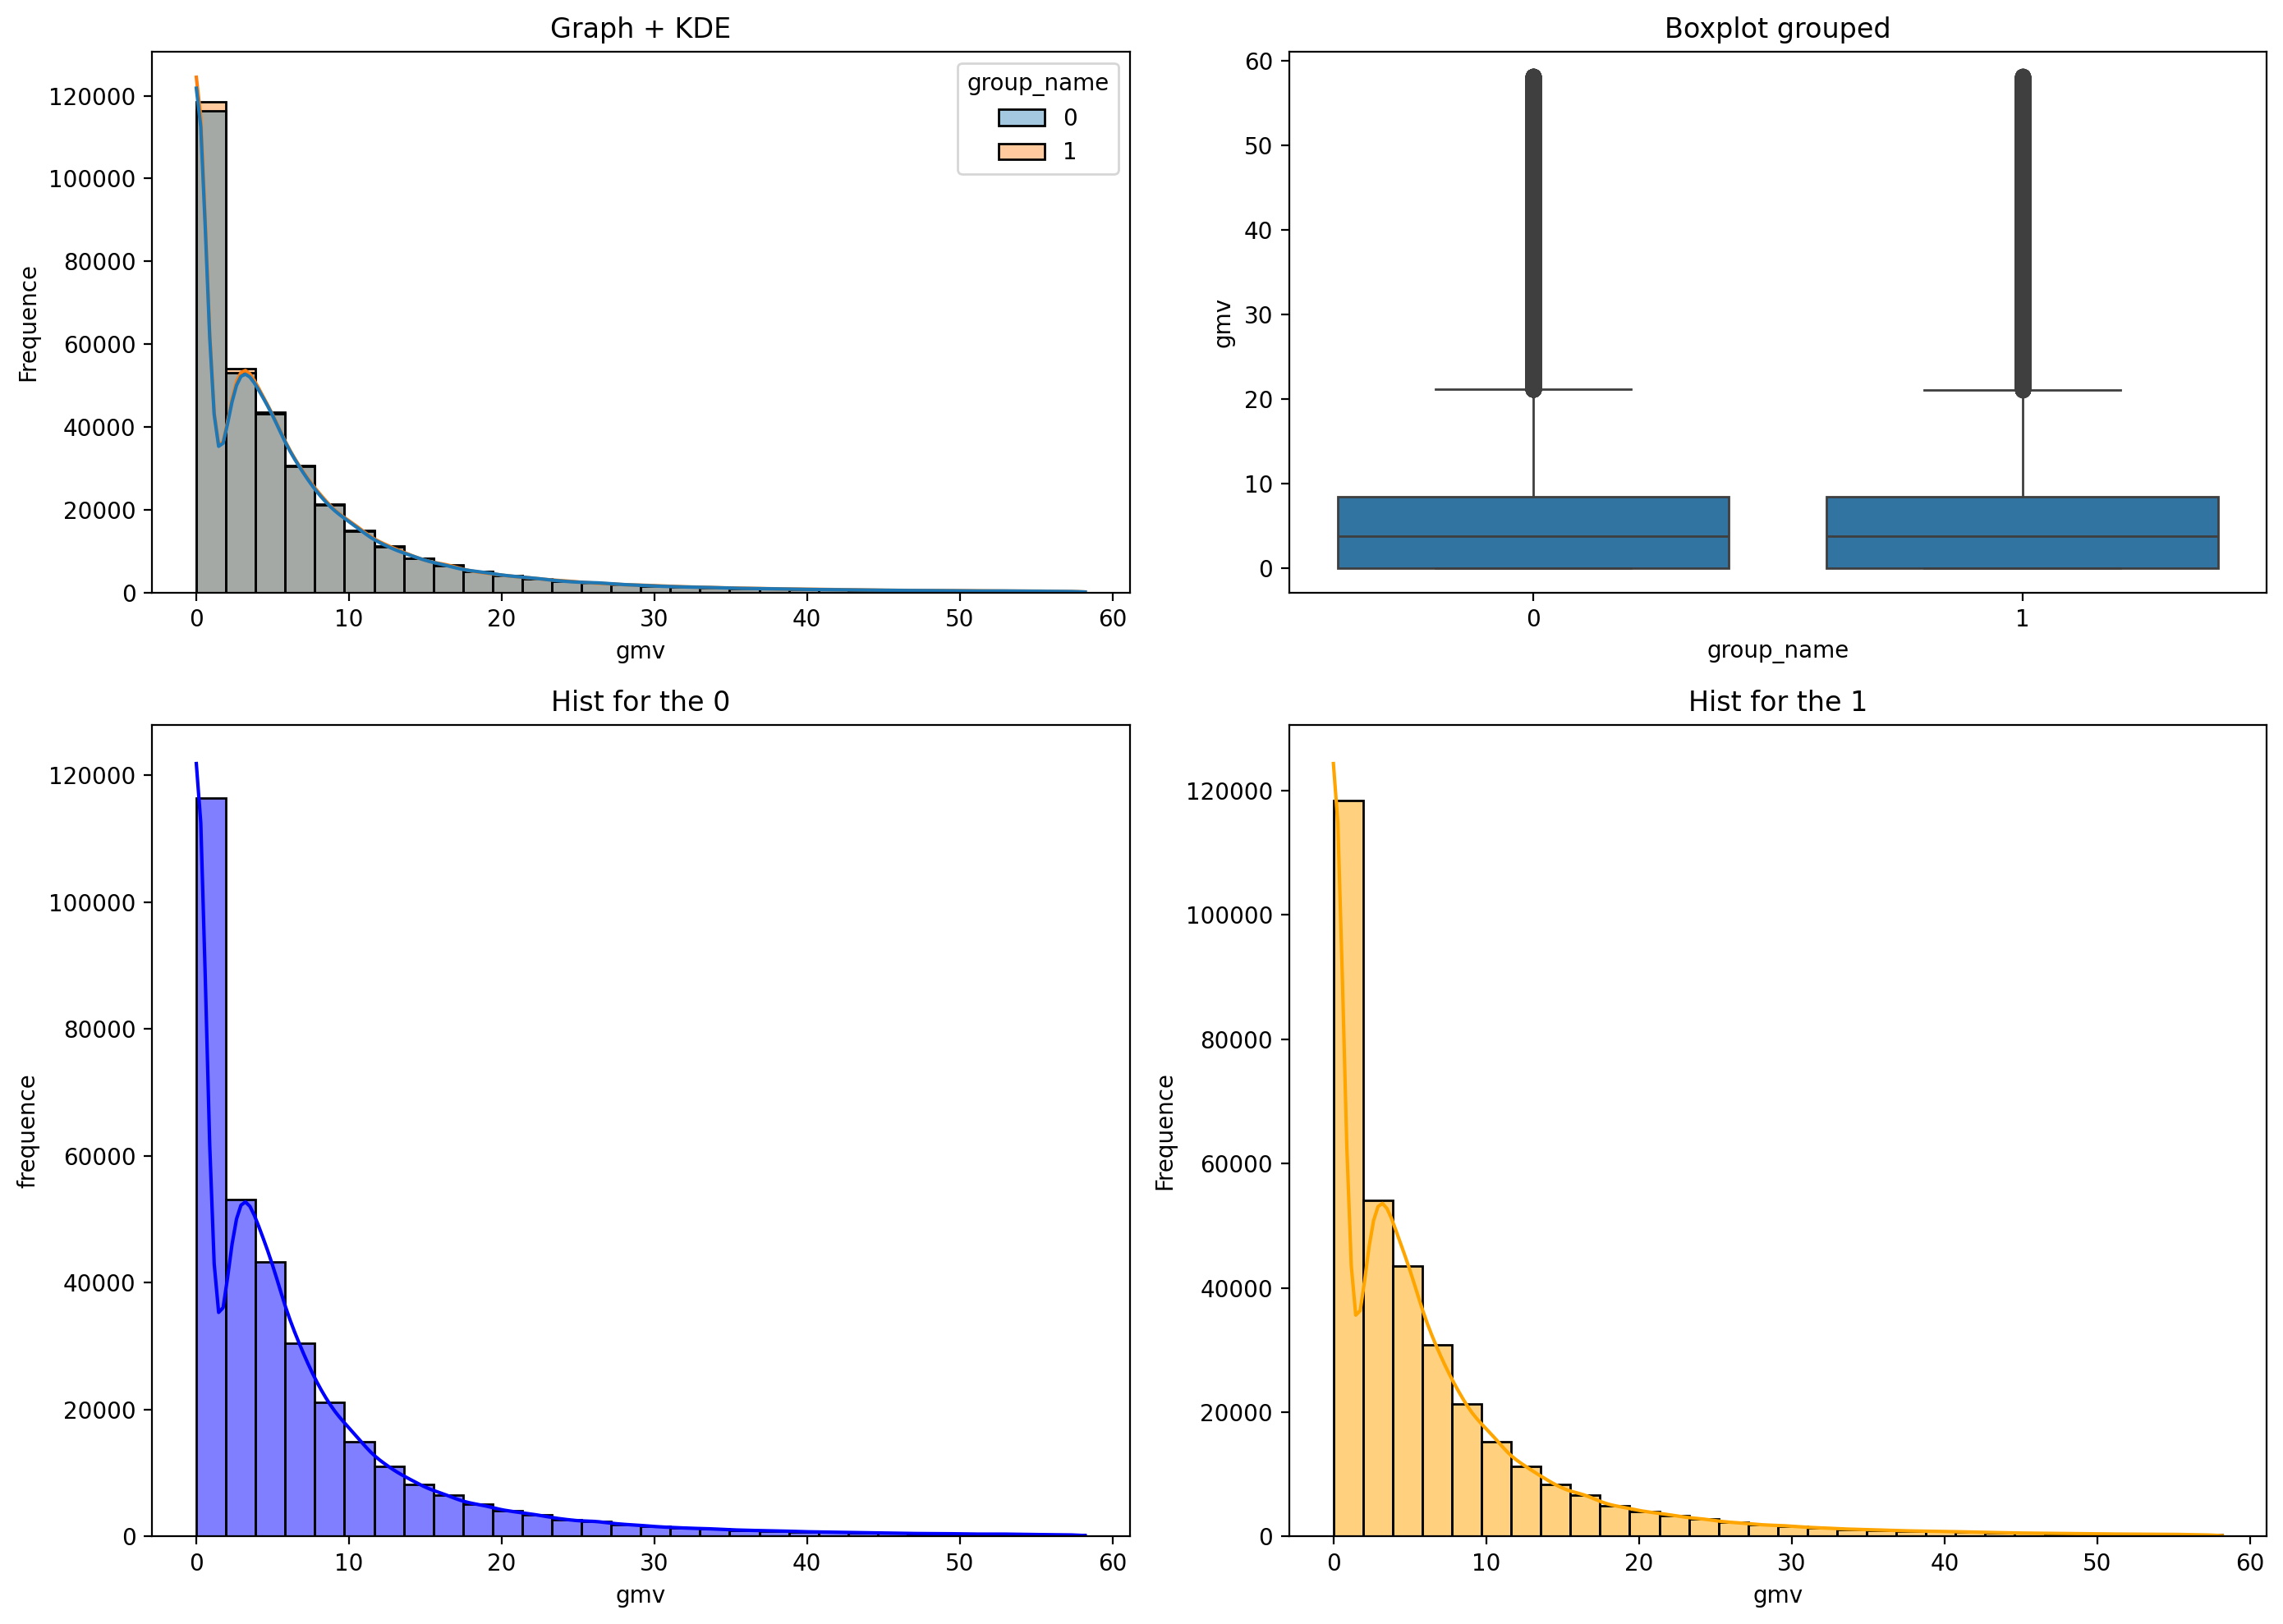

In [92]:
plot_distribution(quant_metrics_corr, 'group_name', 'gmv')

In [103]:
levene(quant_metrics_corr, 'gmv')

Variance are from the same population on mean, 0.053878899711830554


In [117]:
metric = ['gmv', 'rides_count', 'orders_count']
res_df = pd.DataFrame()

for feature in metric:
    res = expab.ttest(quant_metrics_corr, f'{feature}', 'group_name')
    res_df = pd.concat([res_df, res])

res_df

,metric_name,group0_sample_size,group1_sample_size,group0,group1,statistic,pvalue,mean0,mean1,diff_mean,diff_mean_%,lb,ub,lb_%,ub_%
0,gmv,351405,351983,0,1,-3.18,0.00,6.11,6.17,0.06,1.06,0.02,0.10,0.41,1.71
0,rides_count,351405,351983,0,1,-3.06,0.00,1.52,1.54,0.02,1.10,0.01,0.03,0.39,1.80
0,orders_count,351405,351983,0,1,-6.75,0.00,3.63,3.70,0.08,2.14,0.06,0.10,1.52,2.76


In [174]:
quant_metrics

,user_id,city_id,group_name,orders_count,rides_count,gmv
0,198375800,4516,0,29,15,32.03
1,79116504,4264,0,24,15,42.96
2,263676162,4269,0,32,22,72.10
3,282809205,4199,0,27,17,64.93
4,282517783,4143,1,30,26,87.87
...,...,...,...,...,...,...
710489,273834563,5528,0,10,9,28.79
710490,244545265,5535,0,11,9,20.65
710491,283751139,4200,0,59,9,60.32
710492,283501364,4199,1,28,9,17.16


In [181]:
(
    (quant_metrics[quant_metrics['group_name']==1]['gmv'].sum(), quant_metrics[quant_metrics['group_name']==0]['gmv'].sum()),
    quant_metrics[quant_metrics['group_name']==1]['gmv'].sum() - quant_metrics[quant_metrics['group_name']==0]['gmv'].sum(),
    (quant_metrics[quant_metrics['group_name']==1]['rides_count'].sum(), quant_metrics[quant_metrics['group_name']==0]['rides_count'].sum()),
    quant_metrics[quant_metrics['group_name']==1]['rides_count'].sum() - quant_metrics[quant_metrics['group_name']==0]['rides_count'].sum(),
    (quant_metrics[quant_metrics['group_name']==1]['orders_count'].sum(), quant_metrics[quant_metrics['group_name']==0]['orders_count'].sum()),
    quant_metrics[quant_metrics['group_name']==1]['orders_count'].sum() - quant_metrics[quant_metrics['group_name']==0]['orders_count'].sum()
    )



((2482182.9139770665, 2457902.678662272),
 24280.23531479435,
 (612873, 606736),
 6137,
 (1428367, 1399551),
 28816)

### Applying the test for significance calculating

In [154]:
res_df = pd.concat([res_df_cr, res_df])

In [157]:
res_df['significance'] = (res_df['pvalue']<0.05)*1
res_df['corrected_pvalue'] = method_benjamini_hochberg(res_df['pvalue'].values)

In [158]:
res_df

,metric_name,group0_sample_size,group1_sample_size,group0,group1,statistic,pvalue,mean0,mean1,diff_mean,diff_mean_%,lb,ub,lb_%,ub_%,significance,corrected_pvalue
0,has_cancel,335832,336377,0,1,-26.18,0.00,0.32,0.35,0.03,9.41,0.03,0.03,8.70,10.11,1,1
0,has_ride,336103,336618,0,1,-4.35,0.00,0.53,0.53,0.01,1.00,0.00,0.01,0.55,1.45,1,1
0,gmv,351405,351983,0,1,-3.18,0.00,6.11,6.17,0.06,1.06,0.02,0.10,0.41,1.71,1,1
0,rides_count,351405,351983,0,1,-3.06,0.00,1.52,1.54,0.02,1.10,0.01,0.03,0.39,1.80,1,1
0,orders_count,351405,351983,0,1,-6.75,0.00,3.63,3.70,0.08,2.14,0.06,0.10,1.52,2.76,1,1


# Checking the OS systems separately

In [12]:
df_check = read_bq("""
WITH users AS (SELECT DISTINCT t1.user_id,
                               t2.os_name,
                               t1.city_id,
                               r.city_name,
                               r.country_id,
                               r.country_name,
                               created_dt_part,
                               client_time,
                               CASE
                                   WHEN group_id = 4534130 THEN 0
                                   WHEN group_id = 4534131 THEN 1
                                   ELSE NULL
                                   END group_name
               FROM indriver-e6e40.ss_ab_platform_mart.markup_users t1
                        JOIN indriver-e6e40.heap.vw_macroregion_mapping r
                             ON
                                 t1.city_id = r.city_id
                        JOIN (SELECT user_id, city_id, os_name, TIMESTAMP_MILLIS(client_time) AS client_time
                              FROM indriver-e6e40.ods_event_tracker.event
                              WHERE event_dt_part BETWEEN '2025-02-24' AND '2025-03-12'
                                AND name IN (
                                  'client.verification_flow_get_status.done'
                                  )
                                AND LOWER(JSON_EXTRACT_SCALAR(payload, '$.status')) = 'approve'
                                AND user_id IS NOT NULL
                              QUALIFY ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY event_dt_part) = 1) t2
                             ON t1.user_id = t2.user_id AND t1.city_id = t2.city_id
               WHERE test_id = 2591),
     newbies AS (SELECT user_id,
                        metric_date
                 FROM indriver-bi.incity.tbl_incity_growth_metrics_detail
                 WHERE user_type = 'pass'
                   AND rides_count > 0
                   AND metric_date >= '2023-06-01'),
     total AS (SELECT t1.*,
                      t2.user_id                       AS user_id_rides,
                      t2.metric_date,
                      IF(t2.user_id IS NOT NULL, 0, 1) AS newbie_flag
               FROM users t1
                        LEFT JOIN newbies t2 ON t1.user_id = t2.user_id AND t2.metric_date < t1.created_dt_part
               QUALIFY ROW_NUMBER() OVER (PARTITION BY t1.user_id ORDER BY t2.metric_date DESC) = 1),
     rides AS (SELECT order_uuid,
                      user_id    AS pass_id,
                      driver_id,
                      city_id    AS order_city_id,
                      country_id AS order_country_id,
                      status_order,
                      order_timestamp,
                      at_pickup_dttm,
                      departed_pickup_dttm,
                      at_destination_dttm,
                      departed_destination_dttm,
                      driveraccept_timestamp,
                      driverarrived_timestamp,
                      driverstarttheride_timestamp,
                      driverdone_timestamp,
                      clientdone_timestamp,
                      clientcancel_timestamp,
                      drivercancel_timestamp,
                      user_reg_date,
                      driver_reg_date,
                      stage,
                      created_date_order_part,
                      duration_in_seconds
               FROM indriver-e6e40.imart.incity_detail_new_order
               WHERE created_date_order_part >= '2025-02-23'
                 AND status_order = 'RIDE_STATUS_DONE'
                 AND driverstarttheride_timestamp IS NOT NULL
                 AND (clientcancel_timestamp IS NULL
                   AND drivercancel_timestamp IS NULL))
SELECT t1.*,
       t2.order_timestamp,
       IF(t2.order_timestamp IS NOT NULL, 1, 0) AS has_ride
FROM total t1
         LEFT JOIN rides t2
                   ON t1.user_id = t2.pass_id
                       AND order_timestamp BETWEEN client_time AND client_time + INTERVAL 6 HOUR
QUALIFY row_number() OVER (PARTITION BY user_id ORDER BY order_timestamp) = 1
""")

df_check.head()

,user_id,os_name,city_id,city_name,country_id,country_name,created_dt_part,client_time,group_name,user_id_rides,metric_date,newbie_flag,order_timestamp,has_ride
0,10800991,ios,4255,Cali,22,Colombia,2025-03-02,2025-03-02 04:21:39.198000+00:00,1,<NA>,NaT,1,NaT,0
1,18420850,android,4227,Ciudad Juarez,12,Mexico,2025-03-03,2025-03-12 23:00:55.563000+00:00,0,<NA>,NaT,1,NaT,0
2,19487824,android,4255,Cali,22,Colombia,2025-03-11,2025-03-11 11:01:22.810000+00:00,0,<NA>,NaT,1,2025-03-11 11:01:27+00:00,1
3,26983497,android,5589,Osorno,25,Chile,2025-02-27,2025-02-27 12:18:33.192000+00:00,1,26983497,2023-10-11,0,NaT,0
4,27749793,android,5589,Osorno,25,Chile,2025-02-26,2025-03-05 22:20:16.162000+00:00,1,27749793,2025-02-06,0,NaT,0


In [27]:
df_check_agg = df_check.query("newbie_flag == 1").groupby(['os_name', 'group_name'], as_index=False)['has_ride'].mean()

df_check_agg['has_ride'] = df_check_agg['has_ride'].astype('str')

df_check_agg

,os_name,group_name,has_ride
0,android,0,0.4358215028483588
1,android,1,0.44041661642348967
2,ios,0,0.4893736445975252
3,ios,1,0.489903980137316
4,ipados,0,0.3333333333333333
5,ipados,1,0.5


In [25]:
(0.44041661642348967 - 0.4358215028483588)/ 0.4358215028483588 * 100





1.0543567825586868